### Step 3

# Create geological model

#### Import Python libraries

In [48]:
import sys, warnings, numpy as np, matplotlib.pyplot as plt, gdal, rgeomod
warnings.filterwarnings('ignore')
sys.path.append("../../gempy")
import gempy as gp
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

### Step 3b: Define geological model object, load the interface and foliation data files and set model extent

In [2]:
geo_data=gp.create_data(extent=[612000, 622000, 2472000, 2480000, -1000, 1000], 
                        resolution=[50, 50, 50],
                        path_f = "../data/gempy_foliations.csv",
                        path_i = "../data/gempy_interfaces.csv")

### Step 3c: Set stratigraphic order

<div class="alert alert-info">
**Your task:** Enter the correct ordering of formation names as strings in the list variable *order_formations* in the code cell below and execute the following code cell to set the stratigraphic order for the modeling software.
</div>

<div class="alert alert-warning">
**Note**: you can keep the provided names, or adjust them to suit your own definitions
</div>



In [3]:
formation_order = ["Unit4", "Unit3", "Unit2", "Unit1"]

With the code in the next cell, we define the order of the geological formations and obtain an overview of the stratigraphic pile.

<div class="alert alert-warning">
**Note**: We only have one modeling "series" in this case. A series (in this modeling context) is defined as a sequence of (sub-)parallel surfaces. However, the order of the "Units" is important and should reflect the actual relative age ordering you interpret from GoogleEarth.
</div>




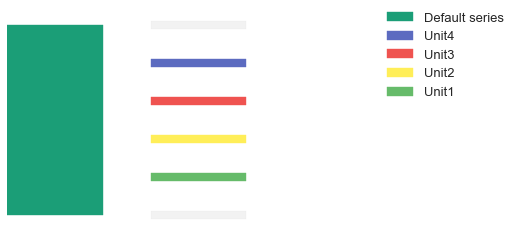

In [4]:
gp.set_series(geo_data, {"Default series": formation_order},
             order_formations = formation_order)


### Step 3d: create plots of raw data in map view and cross sections

<div class="alert alert-info">
**Your task:** Execute the code below to generate a plot of your picked points and processed orientation values. Note: adjust `direction="z"` to `direction="x"` or `direction="y"` to get section views in E-W and N-S directions:
</div>

<div class="alert alert-warning">
**Note**: review carefully at this step if the defined sequence order in the stratigraphic pile is correct!
</div>



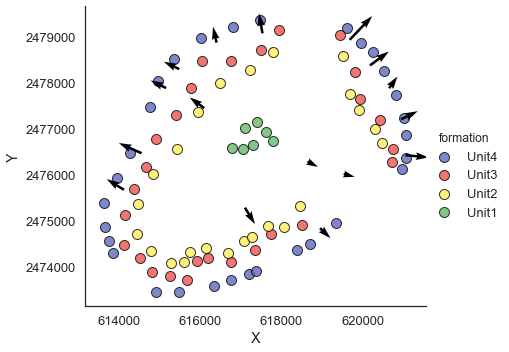

In [5]:
gp.plot_data(geo_data, direction="z")

### Step 3e (optional): visualize input data in 3-D using VTK

<div class="alert alert-info">
**Your task:** Execute the code below to generate a 3-D visualisation in an external VTK-viewer:
</div>


<div class="alert alert-danger">
**Important note**: 3D-Visualization using VTK is not available if you use Docker to run this exercise. This part is **optional**.
</div>

In [6]:
try:
    gp.plot_data_3D(geo_data)
except NameError:
    print("3-D visualization library vtk not installed.")

#### Computing the 3D Model

<div class="alert alert-info">
**Your task:** Execute the following two cells to perform the model interpolation step.
</div>

<div class="alert alert-warning">
**Note**: The following code cell will need several minutes to execute, depending on your system configuration. As this step is compute- and memory-intense, it can also fail (you will then get a "kernal died" warning). If this happens, then check your memory settings (especially if you are using the installtion in a docker container) and re-run the notebook.
</div>

In [7]:
print("Compiling GemPy interpolator...")
interp_data = gp.InterpolatorInput(geo_data, dtype="float64", u_grade=[3])
print("Compilation successful.")

Compiling GemPy interpolator...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Compilation successful.


In [8]:
lith_block, fault_block = gp.compute_model(interp_data)
print("3-D geological model calculated.")

3-D geological model calculated.


### Step 4

## Post-processing results for visualization and interpretation

### 2D Sections

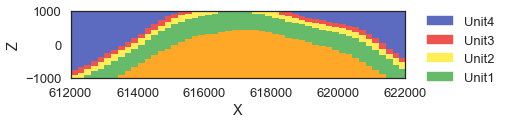

In [8]:
gp.plot_section(geo_data, lith_block[0], 25, direction='y', plot_data=False)

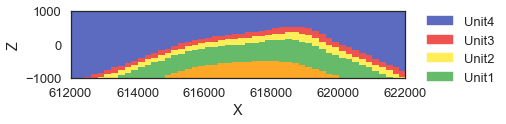

In [24]:
gp.plot_section(geo_data, lith_block[0], 45, direction='y', plot_data=False)

### Pseudo-3D surfaces

From the interpolated block model we can extract the `vertices` and `simplices` to construct layer interfaces for 3-D visualization:

In [10]:
vertices, simplices = gp.get_surfaces(interp_data, potential_lith=lith_block[1], step_size=2)

Although the main Python plotting library `matplotlib`is designed for 2-D visualization, it has some support for pseudo-3-D visualization:

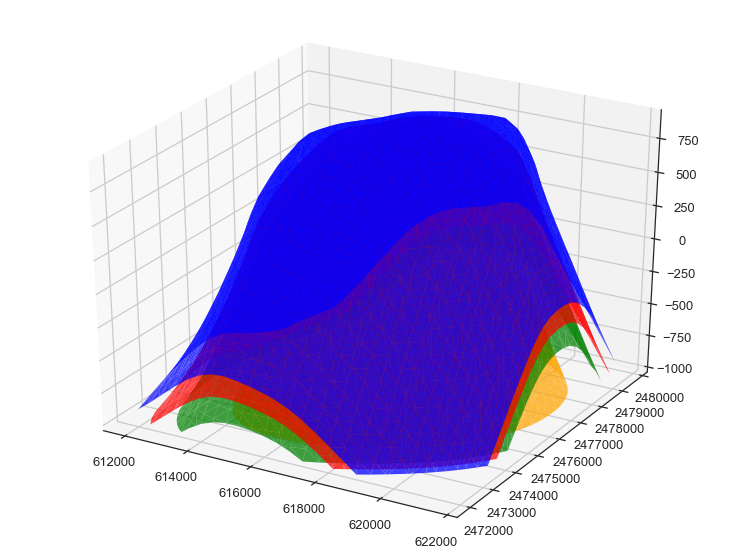

In [13]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')
cs = ["blue", "red", "green", "orange"]
for i in range(4):
    surf = ax.plot_trisurf(vertices[i][:,0], vertices[i][:,1], vertices[i][:,2], 
                           color=cs[i], linewidth=0, alpha=0.75, shade=False)

### 3D Visualization using VTK

For actual 3-D visualization we can make use of the 3-D visualization library `vtk` to look at the interpolated geological model in a more intuitive and flexible way. 

<div class="alert alert-danger">
**Important note**: 3D-Visualization using VTK is not available if you use Docker to run this exercise. This part is **optional**.
</div>

In [27]:
try:
    gp.plot_surfaces_3D(geo_data, v_l, s_l)
except NameError:
    print("3-D visualization library vtk not installed.")

### Creating a geological map

We can now intersect the interpolated geological model with the digital terrain model to create a geological map.

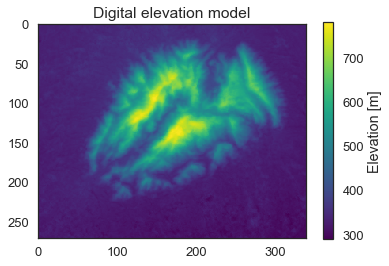

In [22]:
# load the digital elevation model
geotiff_filepath = "../data/dome_sub_sub_utm.tif"
raster = gdal.Open(geotiff_filepath)
dtm = raster.ReadAsArray()
dtmp = plt.imshow(dtm, origin='upper', cmap="viridis");
plt.title("Digital elevation model");
plt.colorbar(dtmp, label="Elevation [m]")

Build basic gempy using _data_ extent (_resolution_ does not matter  for the interpolation but yes for the visualization):

In [26]:
# here are the raster dimensions:
raster.RasterXSize, raster.RasterYSize
geoinformation = raster.GetGeoTransform()
# get DTM corners:
dtm_E_min = geoinformation[0]
dtm_E_max = geoinformation[0] + geoinformation[1] * raster.RasterXSize
dtm_N_min = geoinformation[3] + geoinformation[5] * raster.RasterYSize
dtm_N_max = geoinformation[3]
dtm_E_min, dtm_E_max, dtm_N_min, dtm_N_max

# define range for x, y - values
X_range = np.arange(dtm_E_min, dtm_E_max, geoinformation[1])
Y_range = np.arange(dtm_N_min, dtm_N_max, np.abs(geoinformation[5]))
XX, YY = np.meshgrid(X_range, Y_range, indexing="ij")

# Create list of input points for interpolation with gempy:
points = np.array(list(zip(XX.ravel(), YY.ravel(), dtm[::-1,:].T.ravel())))

geo_data_geomap = gp.create_data(extent=[612000, 622000, 2472000, 2480000, -1000, 1000],  
                                 resolution=[339, 271, 1], 
                                 path_f = "../data/gempy_foliations.csv",
                                 path_i = "../data/gempy_interfaces.csv")

gp.set_series(geo_data_geomap, {"Default series": formation_order},
             order_formations = formation_order, verbose=0)

#N ow here the "trick": replace grid points with DTM grid points:
geo_data.grid.grid = points

Perform the "usual" interpolation step:

In [27]:
interp_data_geomap = gp.InterpolatorInput(geo_data, dtype="float64")
lith_block, fault_block = gp.compute_model(interp_data_geomap)

Level of Optimization:  fast_run
Device:  cpu
Precision:  float64


And here **the geological map**:

In [50]:
geo_map.shape

(339, 271)

Text(0.5,1,'Geological map')

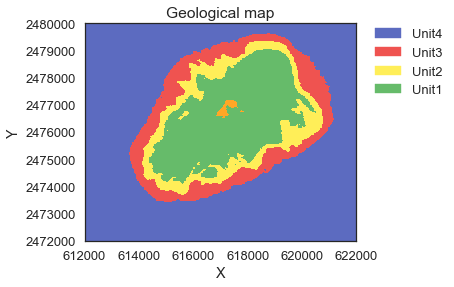

In [28]:
gp.plot_section(geo_data_geomap, lith_block[0], 0, direction='z', plot_data=False)
plt.title("Geological map");

Executing the following code will export a GeoTiff inside the data folder which can be loaded into Google Earth:

In [45]:
geo_map = lith_block[0].copy().reshape((339,271))
geo_map = geo_map.astype('int16')  # change to int for later use

### Export the map for visualization in GoogleEarth

In [47]:
rgeomod.export_geotiff("../data/geomap.tif", geo_map, gp.colors.cmap, geotiff_filepath)

Successfully exported geological map to ../data/geomap.tif
